In [3]:
from qiskit import *

# Zadanie 1

### Podejście "książkowe"

In [149]:
def hadamard_slice(circ, end_cubit):
    for i in range(end_cubit + 1):
        circ.h(i)
    return circ

In [161]:
def V(circ, a):
    for i in range(len(a)):
        if not a[i]:
            circ.x(i)
    circ.mcx(list(range(len(a))), len(a))
    for i in range(len(a)):
        if not a[i]:
            circ.x(i)
    return circ

In [143]:
def W(circ, a):
    circ = hadamard_slice(circ, len(a) - 1)
    for i in range(len(a)):
        circ.x(i)
    circ.barrier()
    circ.h(len(a) - 1)
    circ.mcx(list(range(len(a) - 1)), len(a) - 1)
    circ.h(len(a) - 1)
    circ.barrier()
    for i in range(len(a)):
        circ.x(i)
    circ = hadamard_slice(circ, len(a) - 1)
    return circ

In [174]:
def classic_grover(a = [True, True], iters = 1, measure=True):
    circ = QuantumCircuit(len(a) + 1, len(a))
    circ.x(len(a))
    circ.barrier()
    hadamard_slice(circ, len(a))
    for i in range(iters):
        circ.barrier()
        V(circ, a)
        circ.barrier()
        W(circ, a)
    if measure:
        for i in range(len(a)):
            circ.measure(i, i)
    return circ

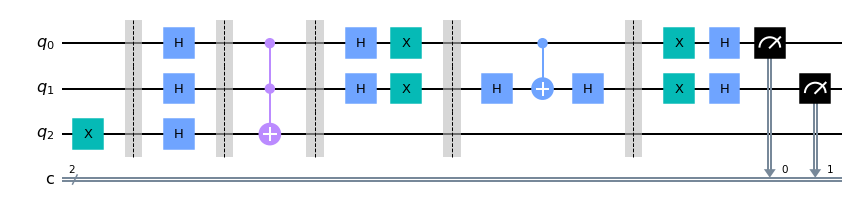

In [134]:
circ = classic_grover()
circ.draw("mpl")

In [14]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
def get_quantum_instance(n):

    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')

    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits > n and
                                       not x.configuration().simulator and x.status().operational==True))
    print("least busy backend: ", backend)
    return backend

In [8]:
from qiskit import transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

def simulate(circ, backend=QasmSimulator()):
    qc_compiled = transpile(circ, backend, optimization_level=3)
    job_sim = backend.run(qc_compiled, shots=2048)
    result_sim = job_sim.result()
    return result_sim.get_counts(qc_compiled)

In [128]:
sim_result = simulate(circ)
sim_result

{'11': 2048}

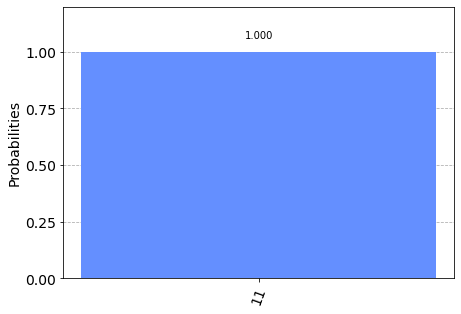

In [80]:
plot_histogram(sim_result)

In [7]:
from qiskit.tools.monitor import job_monitor

def run_on_machine(circ, backend):
    qc_compiled = transpile(circ, backend, optimization_level=1)
    job = backend.run(qc_compiled, shots=4096)
    job_monitor(job, interval = 1)
    result = job.result()
    return result.get_counts()

In [81]:
machine_result = run_on_machine(circ, get_quantum_instance(3))

ibmqfactory.load_account:WARNING:2022-05-26 23:06:42,109: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_belem
Job Status: job has successfully run


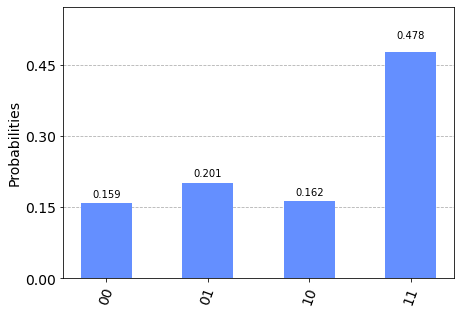

In [82]:
plot_histogram(machine_result)

### Podejście z optymalizacjami

In [4]:
def grover_opt():
    grover_circuit = QuantumCircuit(2, 2)
    grover_circuit.h([0,1])
    grover_circuit.cz(0,1)
    grover_circuit.h([0,1])
    grover_circuit.z([0,1])
    grover_circuit.cz(0,1)
    grover_circuit.h([0,1])
    grover_circuit.measure_all()
    return grover_circuit

In [5]:
circ_2 = grover_opt()

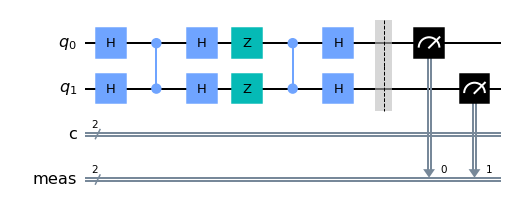

In [6]:
circ_2.draw("mpl")

In [9]:
result = simulate(circ_2)
result

{'11 00': 2048}

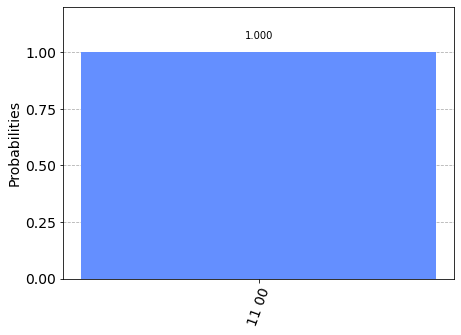

In [11]:
plot_histogram(result)

In [15]:
machine_result = run_on_machine(circ_2, get_quantum_instance(2))

least busy backend:  ibmq_lima
Job Status: job has successfully run


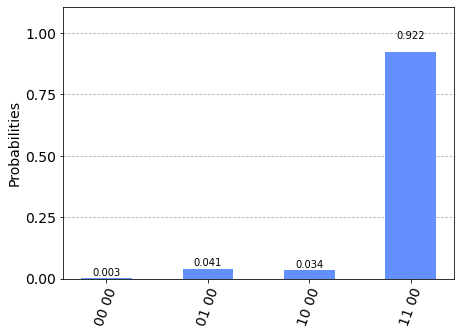

In [16]:
plot_histogram(machine_result)

# Zadanie 2

In [189]:
n = 3
a = [True, True, False]

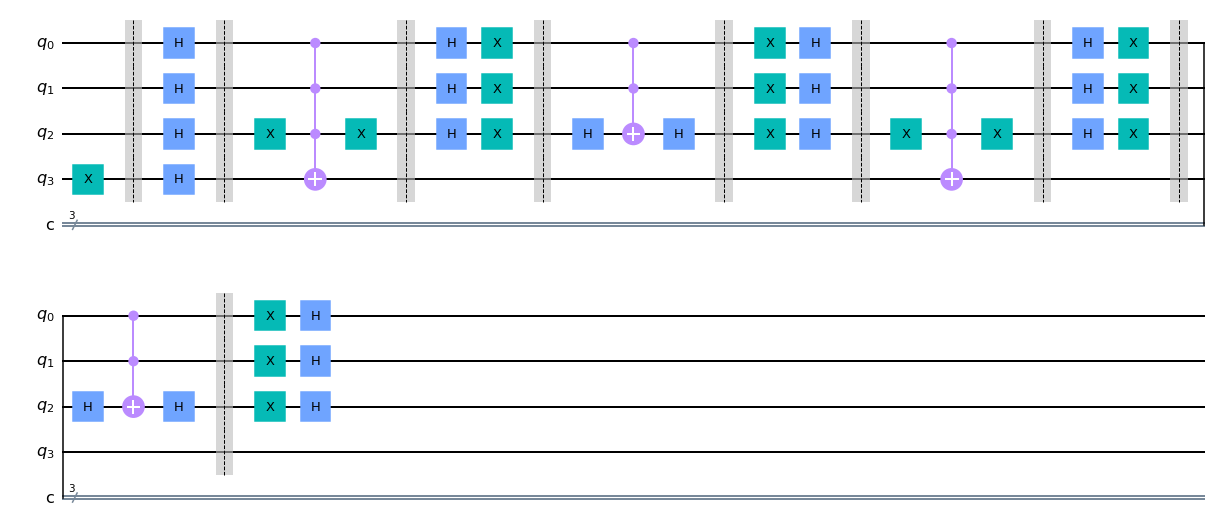

In [190]:
from qiskit.circuit.library import MCMT
circ=classic_grover(a=a, iters=2, measure=False)
circ.draw("mpl")

In [178]:
from qiskit.quantum_info import Statevector

def draw(qc, n):
    state = Statevector.from_int(0, 2**(n + 1))
    state = state.evolve(qc)
    return state.draw("latex")

In [191]:
expected = QuantumCircuit(n)
expected.x(0)
expected.x(1)
draw(expected, n)

<IPython.core.display.Latex object>

In [196]:
actual = QuantumCircuit(n+1, n)
actual.x(n)
actual.barrier()
hadamard_slice(actual, n)
draw(actual, n)

<IPython.core.display.Latex object>

In [197]:
V(actual, a)
draw(actual, n)


<IPython.core.display.Latex object>

In [198]:
W(actual, a)
draw(actual, n)

<IPython.core.display.Latex object>

In [199]:
V(actual, a)
draw(actual, n)

<IPython.core.display.Latex object>

In [200]:
W(actual, a)
draw(actual, n)

<IPython.core.display.Latex object>

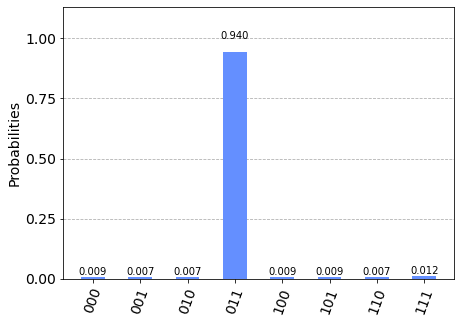

In [202]:
for i in range(n):
    actual.measure(i, i)

plot_histogram(simulate(actual))